<a href="https://colab.research.google.com/github/MariaEspFon/Scripts-propios/blob/main/TensorFlow/CNN_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# PRUEBAS CON DATASET 7

19 características
TEMPORALES: media, mediana, desv.típica, max, min, desv.típica 1ªdif, mediana 1ªdif, desv.típica 2ªdif, AuC, curtosis
FRECUENCIA: potencia, banda de potencia 99%, máximo de la BW99%
TÓNICA: Auc, media, desv.típica
FÁSICA: Auc, media, desv.típica

## 1. Inicialización de Keras y TensorFlow

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

print("TensorFlow version: ", tf.__version__)

from tensorflow import keras
#print("Keras version: ", tf.keras.__version__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from math import ceil

%reload_ext tensorboard

## 2. Carga de datos EDA desde Github

In [ ]:
x = input('Código del dataset: ')
if x == '7':
  url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_D7_median.csv'
  column_names = ['Mean','Median', 'Standard Dev', 'Max Value', 'Min Value', 'Standard Dev 1st diff', 'Median 1st diff', 'Standard Dev 2nd diff',
                  'Total Area', 'Kurtosis', 'SCR','Power', '99% Bandwidth', 'Top Bandwidth Frequency',
                  'Phasic mean', 'Phasic Stdev', 'Phasic AuC', 'Tonic mean', 'Tonic Stdev', 'Tonic AuC',
                'State']
elif x=='1':
  url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_D1.csv'
  column_names = ['Median', 'Standard Dev', 'Max Value', 'Min Value', 'Total Area', 'nº SCR', 'Power', 'State']
elif x=='2.1':
  url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_D21.csv'
  column_names = ['Median', 'Standard Dev', 'Max Value', 'Min Value', 'Standard Dev 1st diff','Median 1st diff', #'Standard Dev 2nd diff',
                'Total Area', 'nº SCR', 'Power', 'State']
elif x=='2.2':
  url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_D22.csv'
  column_names = ['Median', 'Standard Dev', 'Max Value', 'Min Value', 'Standard Dev 1st diff', 'Median 1st diff',
                'nº SCR', 'Total Area', 'Power', 'State']
elif x=='3':
  url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_D3.csv'
  column_names = ['Median', 'Standard Dev', 'Max Value', 'Min Value', 'Standard Dev 1st diff', 'Median 1st diff', #'Standard Dev 2nd diff',
                'Total Area', 'nº SCR', 'State']
elif x=='4':
  url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_D4.csv'
  column_names = ['Median', 'Standard Dev', 'Max Value', 'Min Value', 'Standard Dev 1st diff', 'Median 1st diff',
                'Total Area', 'Power', 'State']
elif x=='5':
  url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_D5.csv'
  column_names = ['Mean', 'Median', 'Standard Dev', 'Max Value', 'Min Value',
                'Standard Dev 1st diff','Median 1st diff', 'Standard Dev 2nd diff',
                'Total Area', 'Kurtosis', 'Power', '99% Bandwidth', 'Top Bandwidth Frequency','State']
elif x=='6':
  url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_D6.csv'
  column_names = ['Mean','Median', 'Standard Dev', 'Max Value', 'Min Value',
                'Standard Dev 1st diff', 'Median 1st diff', 'Standard Dev 2nd diff',
                'Kurtosis', '99% Bandwidth', 'Top Bandwidth Frequency','State']
else: print('Error: ingrese un código válido')

In [ ]:
raw_dataset = pd.read_csv(url, names=column_names, sep=',', skipinitialspace=True)
clean_dataset = raw_dataset.dropna()

size = clean_dataset.shape
print(f'Formato del dataset: {size}')

class_counts = clean_dataset['State'].value_counts()
print("Recuento de instancias por clase:")
print(class_counts)

In [ ]:
clean_dataset.head()  # muestra las primeras 5 filas por defecto

In [ ]:
clean_dataset.tail() # muestra las últimas 5 filas por defecto

## 3. Preprocesamiento de datos

### 3.1. Extracción de los conjuntos de entrenamiento, prueba y validación

*   Datos de **entrenamiento**: para el aprendizaje de parámetros.
*   Datos de **prueba**: para hacer test de predicciones.
*   Datos de **validación**: para afinar hiperparámetros.



In [5]:
# Extracción de subconjuntos: bloque de código para mantener la proporción de clases
from sklearn.model_selection import train_test_split

features = clean_dataset.drop('State', axis=1)
labels = clean_dataset['State']
train_dataset, test_dataset, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=0)

In [ ]:
train_size = train_dataset.shape
test_size = test_dataset.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')

train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

### 3.2. Normalización y estandarización de todos los datos

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
train_size = normed_train_data.shape
test_size = normed_test_data.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')

normed_train_stats = normed_train_data.describe()
normed_train_stats = normed_train_stats.transpose()
normed_train_stats

## 4. Creación del modelo CNN

El primer modelo cuenta con 2 tipos de capas:
*     Capas convolucionales con un número variable de filtros de (2x1) o (3x1).
*     Capas densas en la salida para integrar toda la información convolucional y hacer la clasificación binaria (para la cual sólo es necesaria una neurona y una función sigmoid de activación).

Además, se incluye una capa accesoria para preparar los datos antes de la capa de salida (capa Flatten)

In [8]:
from keras import Sequential, layers, activations

### 4.1 Modelos A y B

In [ ]:
def build_model_A(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_A(train_size)
model.summary()

In [ ]:
def build_model_B(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.Conv1D(22, 3, padding='same'))
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_B(train_size)
model.summary()

### 4.2 Modelos C

In [ ]:
def build_model_C1(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(18, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_C1(train_size)
model.summary()

In [ ]:
def build_model_C2(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.Conv1D(22, 3, padding='same', activation='relu'))
  model.add(layers.Conv1D(18, 3, padding='same', activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_C2(train_size)
model.summary()

In [ ]:
def build_model_C3(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(18, 4, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_C3(train_size)
model.summary()

In [ ]:
def build_model_C4(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.Conv1D(22, 3, padding='same', activation='relu'))
  model.add(layers.Conv1D(18, 4, padding='same', activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_C4(train_size)
model.summary()

### 4.3 Modelos D

In [ ]:
def build_model_D1(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(18, 4, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(9, 5, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_D1(train_size)
model.summary()

In [ ]:
def build_model_D2(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='valid', activation='relu', input_shape=(size[1],1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='valid', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(18, 4, padding='valid', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(9, 5, padding='valid', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_D2(train_size)
model.summary()

In [ ]:
def build_model_D3(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', input_shape=(size[1],1)))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.Conv1D(22, 3, padding='same'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.Conv1D(18, 4, padding='same'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.Conv1D(9, 5, padding='same'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  # compilación del modeo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_D3(train_size)
model.summary()

In [ ]:
def build_model_D4(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='valid', input_shape=(size[1],1)))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.Conv1D(22, 3, padding='valid'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.Conv1D(18, 4, padding='valid'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.Conv1D(9, 5, padding='valid'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  # compilación del modeo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_D4(train_size)
model.summary()

## 5. Entrenamiento del modelo

Reservamos el 20% de los datos de entrenamiento para la validación del modelo

In [ ]:
from keras import callbacks
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # o 'val_accuracy'
    patience=100,              # número de épocas que espera sin mejora
    restore_best_weights=True  # para recuperar los mejores pesos
)

In [13]:
EPOCHS = 1000
#BATCH_SIZE = train_size[0]
BATCH_SIZE = ceil(train_size[0]*0.1)
history = model.fit(normed_train_data, train_labels, batch_size=BATCH_SIZE,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0)

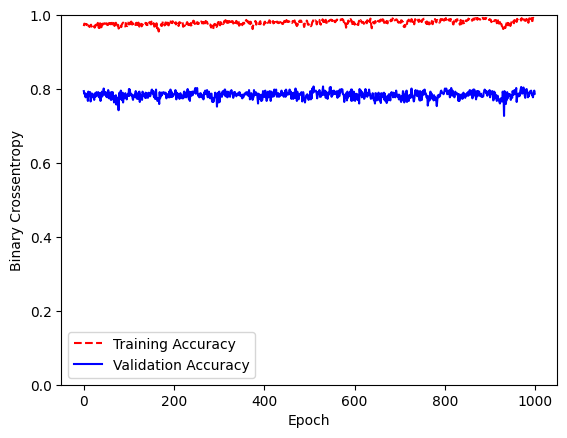

In [25]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Binary Crossentropy')
  plt.plot(hist['epoch'], hist['binary_accuracy'],'r--',
           label='Training Accuracy')
  plt.plot(hist['epoch'], hist['val_binary_accuracy'],'b',
           label = 'Validation Accuracy')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)

## 6. Validación del modelo con los datos de test


In [17]:
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(normed_test_data, test_labels, batch_size=(test_size[0]))
print(f'Test accuracy: {100*test_acc:.2f}%')
print(f'Test loss: {test_loss:.3f}')
# TensorFlow imprime las métricas en orden alfabético por defecto en la consola,
# pero el método evaluate() devuelve los valores en el mismo orden en que fueron definidos en model.compile().

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step - binary_accuracy: 0.8154 - f1_score: 0.7841 - loss: 1.6077 - precision: 0.8748 - recall: 0.8157
Test accuracy: 81.54%
Test loss: 1.608


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


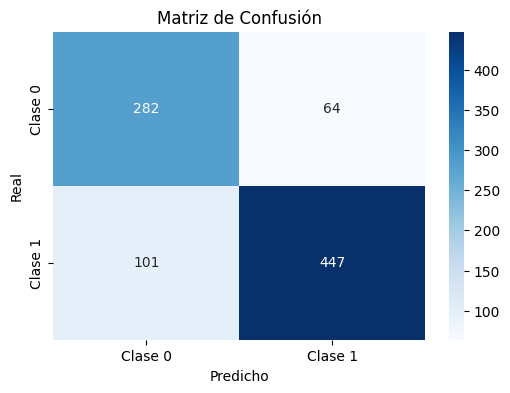

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.74      0.82      0.77       346
     Clase 1       0.87      0.82      0.84       548

    accuracy                           0.82       894
   macro avg       0.81      0.82      0.81       894
weighted avg       0.82      0.82      0.82       894



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

predictions = model.predict(normed_test_data)
predicted_labels = (predictions > 0.5).astype(int)
cm = confusion_matrix(test_labels, predicted_labels)

# Muestra la matriz de confusión
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

plot_confusion_matrix(cm)

# Muestra métricas adicionales
print("Reporte de clasificación:")
print(classification_report(test_labels, predicted_labels, target_names=['Clase 0', 'Clase 1']))
